Open In Colab

# House Price Prediction based on Postal Code, Number of Bathrooms, Car Parking and Property Type

Detail on Data: https://www.kaggle.com/mihirhalai/sydney-house-prices

# Download source data from Github
!wget https://raw.githubusercontent.com/DLPY/Regression-Session-2/master/Data/SydneyHousePrices.csv

# Import necessary packages for performing EDA and Multiple Regression

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, StandardScaler)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
from sklearn.metrics import (r2_score, mean_squared_error)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

pd.set_option('display.max_colwidth', None)

# Read data from csv file into Pandas dataframe

In [2]:
df = pd.read_csv('C:/Users/jsmith3/Documents/Python Scripts/data/SydneyHousePrices.csv')
# df = pd.read_csv('SydneyHousePrices.csv')

# Exploratory Data Analysis (EDA)
Perform data analysis, cleaning and transformation.

## Data Analysis

In [3]:
# Display the count of rows and columns.
df.shape

(199504, 9)

In [4]:
# Review a small sample of the data.
df.head(5)

,Date,Id,suburb,postalCode,sellPrice,bed,bath,car,propType
0,2019-06-19,1,Avalon Beach,2107,1210000,4.0,2,2.0,house
1,2019-06-13,2,Avalon Beach,2107,2250000,4.0,3,4.0,house
2,2019-06-07,3,Whale Beach,2107,2920000,3.0,3,2.0,house
3,2019-05-28,4,Avalon Beach,2107,1530000,3.0,1,2.0,house
4,2019-05-22,5,Whale Beach,2107,8000000,5.0,4,4.0,house


In [5]:
# Review the data types.
df.dtypes

Date           object
Id              int64
suburb         object
postalCode      int64
sellPrice       int64
bed           float64
bath            int64
car           float64
propType       object
dtype: object

##### From the above, notice the different types of data: integer (int64), float (float64), and text (object).
---

### Review the date range.

Additional date-aggregation functions become available when the data type is converted to date format.  

The data type for date range is currently text, which is okay for now.

In [6]:
print('Date ranges from {} to {}'.format(df.Date.min(), df.Date.max()))

Date ranges from 2000-12-01 to 2019-07-06


### Review descriptive statistics of the numerical data.

In [7]:
round(df.describe(), 2)

,Id,postalCode,sellPrice,bed,bath,car
count,199504.00,199504.00,1.995040e+05,199350.00,199504.00,181353.00
mean,99752.50,2196.38,1.269776e+06,3.52,1.89,1.94
std,57591.99,193.05,6.948239e+06,1.07,0.93,1.06
min,1.00,2000.00,1.000000e+00,1.00,1.00,1.00
25%,49876.75,2082.00,7.200000e+05,3.00,1.00,1.00
50%,99752.50,2144.00,9.850000e+05,3.00,2.00,2.00
75%,149628.25,2211.00,1.475000e+06,4.00,2.00,2.00
max,199504.00,4878.00,2.147484e+09,99.00,99.00,41.00


##### From the above max (bed & bath) and min (sellPrice) - It shows the dataset has outliers that need to be removed.
---

In [8]:
# Detailed overview of the dataframe itself.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199504 entries, 0 to 199503
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Date        199504 non-null  object 
 1   Id          199504 non-null  int64  
 2   suburb      199504 non-null  object 
 3   postalCode  199504 non-null  int64  
 4   sellPrice   199504 non-null  int64  
 5   bed         199350 non-null  float64
 6   bath        199504 non-null  int64  
 7   car         181353 non-null  float64
 8   propType    199504 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 13.7+ MB


##### From the above, notice that the Non-Null Count values are different for bed and car.
---

## Data Cleaning

### Explore the missing values

Review the count of non-null values for each column.  These need to be filled in prior to modelling.

In [66]:
df.isnull().sum()

Date          0
Id            0
suburb        0
postalCode    0
sellPrice     0
bed           0
bath          0
car           0
propType      0
Year          0
Month         0
Day           0
Quarter       0
ordDate       0
dtype: int64

### Aggregate the missing values by date
Combining the method from above with the dataframe's groupby method to group missing car/bed values by date.

Plotting the output with the dataframe's plot method to see if there are any pockets of missing data.

<AxesSubplot:xlabel='Date'>

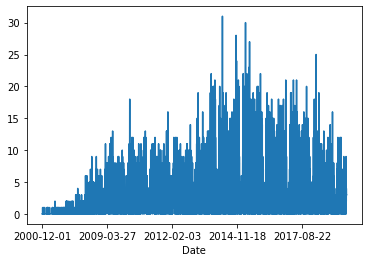

In [10]:
df.groupby(['Date'])['car'].apply(lambda x: x.isnull().sum()).plot()

<AxesSubplot:xlabel='Date'>

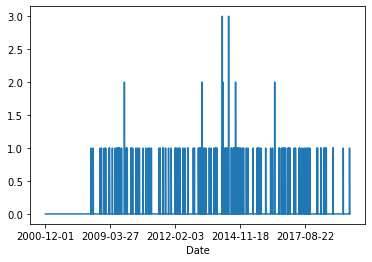

In [11]:
df.groupby(['Date'])['bed'].apply(lambda x: x.isnull().sum()).plot()

### Fill in the missing values
Assuming that houses in a particular area have a similar bath count, missing values can be filled in by:
 1. Grouping postal code and bath.
 2. Calculating the median value of bed and car for each of these groups.
 3. Filling in the missing values with the median count of each group.

In [12]:
df['bed'].fillna(df.groupby(['postalCode', 'bath'])['bed'].transform('median'), inplace=True)

In [13]:
df['car'].fillna(df.groupby(['postalCode', 'bath'])['car'].transform('median'), inplace=True)

### Remove outliers in the data
Using a function that removes the outliers from each column on the list, loop through a list of specific columns that were identified earlier in the EDA as having outliers.

The resulting dataframe does not contain any outliers.

In [14]:
def remove_outlier(df_in, col_name):
    '''Removes outliers from a specified column of a dataframe using IQR and returns an updated dataframe.'''
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 #Interquartile range
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [15]:
outliers = ['bath', 'sellPrice', 'car', 'bed']

for outlier in outliers:
    df = remove_outlier(df, outlier).reset_index(drop=True)

## Transformation

### Transform dates for analysis of sales type prices of property types by year, month.

In [16]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Quarter'] = df['Date'].dt.quarter

<AxesSubplot:xlabel='Month', ylabel='sellPrice'>

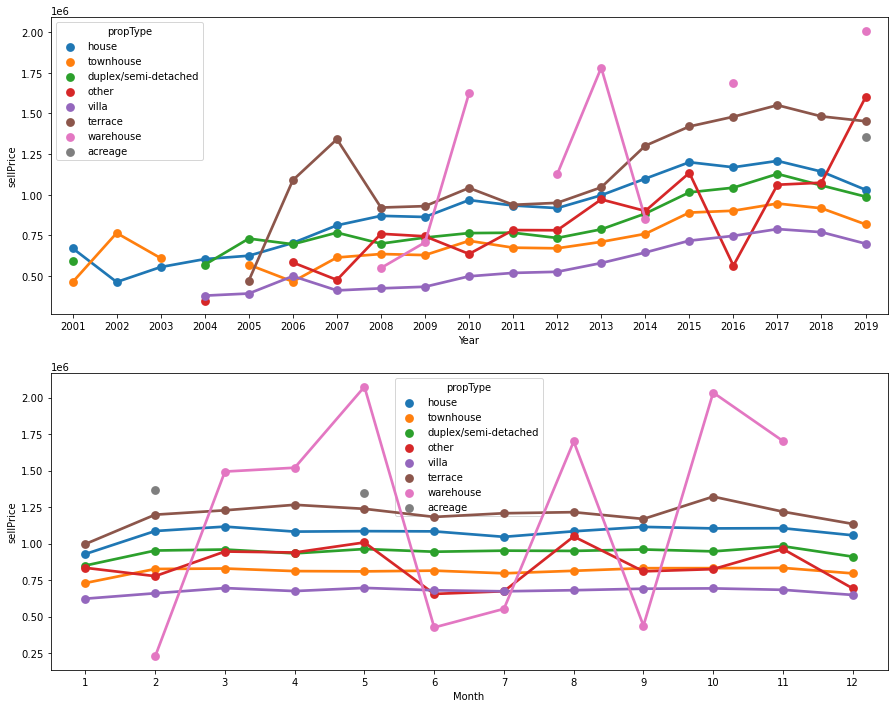

In [17]:
# Plotting sellPrice by year and month.
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
sns.pointplot(data=df, x='Year', y='sellPrice', hue='propType', ax=ax[0], ci=None)
sns.pointplot(data=df, x='Month', y='sellPrice', hue='propType', ax=ax[1], ci=None)

##### From the above, notice the overall seasonal and annual trends of each property type.
---

### Convert Date to datetime and change the dates into ordinal values, counting from 01/01/01
This step is necessary when including date as a feature for linear regression modelling.

In [18]:
# TODO: Change this to days before max date.

# df['Date'] = pd.to_datetime(df['Date']).dt.date
df['ordDate'] = df['Date'].map(dt.date.toordinal)

In [19]:
df['ordDate'].head(5)

0    737229
1    737207
2    737189
3    737162
4    737160
Name: ordDate, dtype: int64

### Encoding the categorical variables - Change the text into numbers

Review the unique values within property type.

In [20]:
df.propType.unique()

array(['house', 'townhouse', 'duplex/semi-detached', 'other', 'villa',
       'terrace', 'warehouse', 'acreage'], dtype=object)

In [21]:
# Drop warehouse and acreage to focus on housing data.
df = df.drop(df[(df.propType == 'warehouse') | (df.propType == 'acreage')].index)

Convert the property type values into numeric categorical labels so that this data can be used in the model.

In [22]:
df['propType'] = df['propType'].astype('category').cat.codes

In [23]:
df.head(5)

,Date,Id,suburb,postalCode,sellPrice,bed,bath,car,propType,Year,Month,Day,Quarter,ordDate
0,2019-06-19,1,Avalon Beach,2107,1210000,4.0,2,2.0,1,2019,6,19,2,737229
1,2019-05-28,4,Avalon Beach,2107,1530000,3.0,1,2.0,1,2019,5,28,2,737207
2,2019-05-10,6,Bilgola Plateau,2107,1610000,4.0,2,2.0,1,2019,5,10,2,737189
3,2019-04-13,7,Avalon Beach,2107,1510000,3.0,1,2.0,1,2019,4,13,2,737162
4,2019-04-11,9,Avalon Beach,2107,1400000,3.0,1,2.0,1,2019,4,11,2,737160


##### From the above, notice that:
 * The propType has been converted to a numeric value. Warehouse and acreage have been removed,to specifically focus on housing.
 * There are new columns: Year, Quarter, ordDate.
 ---

### Quick review - columns that are not useful:
* **Date** - ordDate will be used instead.
* **Id** - This is simply a row number of the data.
* **suburb** - postalCode will be used instead because it is a more generalised representation of location.
* **Year, Month, Day** - Quarter and ordDate will be used because they are generalised representations of Date. 

# Choosing predictors and target variables for performing Multiple Regression
**Target and Source variables**

* **Target Variable:** sellingPrice
* **Predictor Variables:** ordDate, postalCode, bed, bath, car, propType

### Create a new dataframe that includes only the selected columns

In [24]:
df_new = df[['Quarter', 'ordDate', 'postalCode', 'bed', 'bath', 'car', 'propType', 'sellPrice']]

In [25]:
df_new.head(5)

,Quarter,ordDate,postalCode,bed,bath,car,propType,sellPrice
0,2,737229,2107,4.0,2,2.0,1,1210000
1,2,737207,2107,3.0,1,2.0,1,1530000
2,2,737189,2107,4.0,2,2.0,1,1610000
3,2,737162,2107,3.0,1,2.0,1,1510000
4,2,737160,2107,3.0,1,2.0,1,1400000


# Investigate correlation in the new dataframe.

Pandas has a built-in correlation function.

In [26]:
corr = df_new.corr()

In [27]:
# View the correlations within the dataframe.
corr

,Quarter,ordDate,postalCode,bed,bath,car,propType,sellPrice
Quarter,1.000000,-0.033019,-0.016949,-0.005361,-0.004926,-0.007871,-0.003524,0.011452
ordDate,-0.033019,1.000000,0.247113,0.095735,0.042005,0.068235,0.006005,0.203979
postalCode,-0.016949,0.247113,1.000000,0.093534,-0.051130,0.050859,-0.013814,-0.422004
bed,-0.005361,0.095735,0.093534,1.000000,0.595902,0.349496,-0.258585,0.269125
bath,-0.004926,0.042005,-0.051130,0.595902,1.000000,0.336161,-0.051120,0.312592
car,-0.007871,0.068235,0.050859,0.349496,0.336161,1.000000,-0.053399,0.159985
propType,-0.003524,0.006005,-0.013814,-0.258585,-0.051120,-0.053399,1.000000,-0.198107
sellPrice,0.011452,0.203979,-0.422004,0.269125,0.312592,0.159985,-0.198107,1.000000


Create a heatmap chart of the correlations, using a mask to hide redundant information and correct aspect ratio to ensure proper spacing of the chart.

<AxesSubplot:>

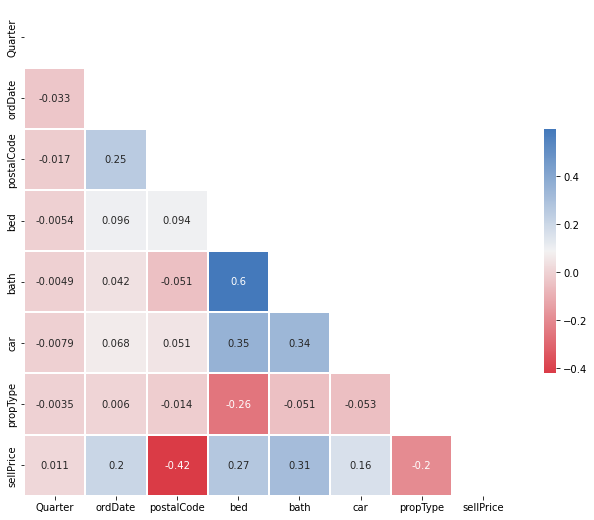

In [28]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 250, as_cmap=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, square=True,
            linewidths=0.2, cbar_kws={'shrink': 0.5}, ax=ax, annot=True)

##### From the above; notice the medium correlation of bed and bath, the negative medium correlation of postCode and sellPrice.  

Multicollinearity has a negative impact on multiple regression models.  The steps for overcoming multicollinearity are different for the chosen model.

* **Training a model and testing on unseen data:** standardize the features.
* **Multiple Regression on entire data set:** a variance inflation factor (VIF) analysis will be used for feature selection.

Either way, the target and predictor variables must be split into different dataframes prior to modelling.

# Isolate Target and Predictor Variables to Different Dataframes

In [29]:
X = df_new[['Quarter', 'ordDate', 'postalCode', 'bed', 'bath', 'car', 'propType']]
y = df_new[['sellPrice']]

# Save this list of column values for later
columns_list = list(X.columns.values)

In [30]:
X.head(5)

,Quarter,ordDate,postalCode,bed,bath,car,propType
0,2,737229,2107,4.0,2,2.0,1
1,2,737207,2107,3.0,1,2.0,1
2,2,737189,2107,4.0,2,2.0,1
3,2,737162,2107,3.0,1,2.0,1
4,2,737160,2107,3.0,1,2.0,1


In [31]:
y.head(5)

,sellPrice
0,1210000
1,1530000
2,1610000
3,1510000
4,1400000


# Standardise Features

Because in linear regression the value of the coefficients is partially determined by the scale of the feature, and in regularized models all coefficients are summed together, the features must be standardised prior to training.

The approach to standardising features is removing the mean and scale to unit variance.

The standard score of a sample x is calculated as:

    z = (x - u) / s

where _u_ is the mean of the training samples and _s_ is the standard deviation of the training samples.

In [32]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [33]:
# The scaled values are now stored as an array.
X_std[: 5]

array([[-0.51582963,  1.52939123, -0.49164012,  0.79180606,  0.3961588 ,
         0.57106709, -0.33475608],
       [-0.51582963,  1.50854559, -0.49164012, -0.43041138, -1.06476085,
         0.57106709, -0.33475608],
       [-0.51582963,  1.49149006, -0.49164012,  0.79180606,  0.3961588 ,
         0.57106709, -0.33475608],
       [-0.51582963,  1.46590678, -0.49164012, -0.43041138, -1.06476085,
         0.57106709, -0.33475608],
       [-0.51582963,  1.46401172, -0.49164012, -0.43041138, -1.06476085,
         0.57106709, -0.33475608]])

In [34]:
# X is already an array data type, so y also needs converting (the model expects these as inputs).
y = y.values

# Split dataset into the training and test using train_set_split: 

90% - train

10% - test

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.1, random_state=23)

In [36]:
print('Training Data:', X_train.shape, y_train.shape)
print('Testing Data:', X_test.shape, y_test.shape)

Training Data: (151499, 7) (151499, 1)
Testing Data: (16834, 7) (16834, 1)


# Train, Test and Predict using ridge and lasso regression models

## Ridge Regression
Create an object called RidgeRegression in the regression class with alpha 0.01

In [37]:
ridgeregressor = Ridge(alpha=0.01)

Fit the linear regression model to the training set. We use the fit method the arguments of the fit method will be training sets

In [38]:
ridgeregressor.fit(X_train, y_train)

Ridge(alpha=0.01)

Regression Coefficients

In [39]:
coefficient = pd.DataFrame(ridgeregressor.coef_)
coefficient.columns = columns_list
coefficient

,Quarter,ordDate,postalCode,bed,bath,car,propType
0,6851.679901,142700.574254,-234467.248603,56302.397325,81973.526586,25236.105213,-75953.791822


### Predicting the results

Training set prediction score

In [40]:
y_pred = ridgeregressor.predict(X_train)

In [41]:
ridge_train_score = ridgeregressor.score(X_train, y_train)
ridge_train_score

0.40513647325203783

Training set prediction score

In [42]:
y_pred = ridgeregressor.predict(X_test)

In [43]:
ridge_test_score = ridgeregressor.score(X_test, y_test)
ridge_test_score

0.3998395017232157

##### From the above, notice that the results of the test data are slightly better than the results of the training data (higher score is better).
This suggests that the model is generalised enough to work well with previously unseen data.

### Evaluation metrics - How to Calculate R-Square and RMSE

In [44]:
print('Ridge results:')
coefficient_of_dermination_ridge = r2_score(y_test, y_pred)
print('R-squared: {}'.format(coefficient_of_dermination_ridge))

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: {}'.format(rmse_ridge))

Ridge results:
R-squared: 0.3998395017232157
Root Mean Squared Error: 359544.0153126222


##### From the above, notice that the results of the R-Square score are the same as the prediction score on the test set.

In [45]:
# Displaying Results and Difference in Table 
res = pd.DataFrame(y_pred, y_test.ravel())
res = res.reset_index()
res.columns = ['Price', 'Prediction']
res['Prediction'] = round(res['Prediction'], 0)
res['Difference'] = res['Prediction'] - res['Price']
res.head(5)

,Price,Prediction,Difference
0,1011000,1015579.0,4579.0
1,1330000,1096752.0,-233248.0
2,2165000,1130628.0,-1034372.0
3,782900,567278.0,-215622.0
4,1610000,1314841.0,-295159.0


In [46]:
res['Difference'].median()

45590.0

## Create an object called RidgeRegression in the regression class with alpha 100

In [47]:
ridgeregressor100 = Ridge(alpha=100)
ridgeregressor100.fit(X_train, y_train)

Ridge(alpha=100)

In [48]:
Coefficient = pd.DataFrame(ridgeregressor100.coef_)
Coefficient.columns = columns_list
Coefficient

,Quarter,ordDate,postalCode,bed,bath,car,propType
0,6845.401547,142561.411533,-234278.100747,56291.36391,81944.252461,25235.325004,-75904.722203


In [49]:
print('Ridge100 results:')
y_pred = ridgeregressor100.predict(X_test)

coefficient_of_dermination_ridge100 = r2_score(y_test, y_pred)
print('R-squared:', coefficient_of_dermination_ridge100)

rmse_ridge100 = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: {}'.format(rmse_ridge100))

Ridge100 results:
R-squared: 0.39984069213918794
Root Mean Squared Error: 359543.6587353799


In [50]:
Ridge_train_score_100 = ridgeregressor100.score(X_train, y_train)
Ridge_train_score_100

0.40513625594187297

In [ ]:
# TODO: PUT TEST SCORE

In [51]:
# Displaying Results and Difference in Table 
res = pd.DataFrame(y_pred, y_test.ravel())
res = res.reset_index()
res.columns = ['Price', 'Prediction']
res['Prediction'] = round(res['Prediction'], 0)
res['Difference'] = res['Prediction'] - res['Price']
res.head(5)

,Price,Prediction,Difference
0,1011000,1015751.0,4751.0
1,1330000,1096804.0,-233196.0
2,2165000,1130549.0,-1034451.0
3,782900,567651.0,-215249.0
4,1610000,1314646.0,-295354.0


In [52]:
res['Difference'].median()

45643.5

## Create an object called Lasso in the regression class with alpha 1

In [53]:
lassoregressor = Lasso(alpha=1, max_iter=10e6)
lassoregressor.fit(X_train, y_train)
print('Coefficients: ', lassoregressor.coef_)

Coefficients:  [   6850.63922069  142699.29535488 -234466.54878189   56304.46919441
   81972.04187837   25235.04399494  -75952.38022076]


In [54]:
Coefficient = pd.DataFrame(lassoregressor.coef_).T
Coefficient.columns = columns_list
Coefficient

,Quarter,ordDate,postalCode,bed,bath,car,propType
0,6850.639221,142699.295355,-234466.548782,56304.469194,81972.041878,25235.043995,-75952.380221


In [55]:
print('Lasso results:')
y_pred= lassoregressor.predict(X_test)

coefficient_of_dermination_lasso = r2_score(y_test, y_pred)
print('R-squared:', coefficient_of_dermination_lasso)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: {}'.format(rmse_lasso))

Lasso results:
R-squared: 0.3998395394390041
Root Mean Squared Error: 359544.0040152391


In [56]:
# Create a list of models, their coefficients, and rmse values.
model_results = [('ridge', coefficient_of_dermination_ridge, rmse_ridge),
                 ('ridge10', coefficient_of_dermination_ridge100, rmse_ridge100),
                 ('lasso', coefficient_of_dermination_lasso, rmse_lasso)]

In [57]:
# Create a dataframe to review the model results.
overall_results = pd.DataFrame(model_results, columns=['Model', 'Coefficient', 'RMSE'])

In [58]:
overall_results

,Model,Coefficient,RMSE
0,ridge,0.399840,359544.015313
1,ridge10,0.399841,359543.658735
2,lasso,0.399840,359544.004015


##### From the above, notice that the overall results are similar. Ridge is the champion model due to the highest RMSE value.
---

Plotting the coefficients of each model displays that the values of each model's coefficients are also quite similar.

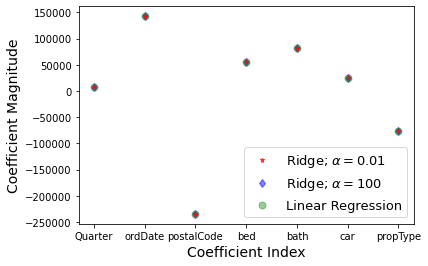

In [59]:
# Note: is this too much information?
plt.plot(ridgeregressor.coef_.ravel(), alpha=0.7, linestyle='none', marker='*', markersize=5,
         color='red', label=r'Ridge; $\alpha = 0.01$', zorder=7) 
plt.plot(ridgeregressor100.coef_.ravel(), alpha=0.5, linestyle='none', marker='d', markersize=6,
         color='blue', label=r'Ridge; $\alpha = 100$') 
plt.plot(lassoregressor.coef_.ravel(), alpha=0.4, linestyle='none', marker='o', markersize=7,
         color='green', label='Linear Regression')
plt.xlabel('Coefficient Index', fontsize=14)
plt.ylabel('Coefficient Magnitude', fontsize=14)
plt.legend(fontsize=13, loc=4)
plt.xticks(range(0, len(columns_list)), columns_list)
plt.show()

# Recap of outputs using these methods

TODO...
example - things to try that will improve the model, such as including additional data e.g. tying Census data to postal code.

---

# VIF

A simple method to detect multicollinearity in a model is by using something called the variance inflation factor or the VIF for each predicting variable.

VIF measures the ratio between the variance for a given regression coefficient with only that variable in the model versus the variance for a given regression coefficient with all variables in the model.

VIF starts at 1 and has no limits. A VIF of 1 (the minimum possible VIF) means the tested predictor is not correlated with the other predictors. A VIF of 1 (the minimum possible VIF) means the tested predictor is not correlated with the other predictors.

The higher the VIF:
* The more correlated a predictor is with the other predictors
* The more the standard error is inflated
* The larger the confidence interval
* The less likely it is that a coefficient will be evaluated as statistically significant

VIF = 1, _no correlation_ beetween independent variables. 

VIF > 10, _high multicollinearity_ between independent variables.

In [60]:
# Create VIF dataframe and calculate VIF for each feature.
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns.values
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,Quarter,6.419931
1,ordDate,152.619860
2,postalCode,132.900202
3,bed,31.869893
4,bath,12.222944
5,car,9.651596
6,propType,2.743183


##### From the above, there are several multicollinear features. 
An additional feature selection step is required, using a custom function to eliminate featuers with high VIF values.

In [61]:
def vif_feature_selection(X, thresh=10):
    '''Iterate through the features and calculate their respective values,
        continuously dropping the highest VIF features until all the features
        have VIF less than the threshold'''
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping {} at index: {}'.format(
                X.iloc[:, variables].columns[maxloc], str(maxloc)))
            del variables[maxloc]
            dropped = True

    print('Remaining variables: {}'.format(list(X.columns[variables])))
    return X.iloc[:, variables]

In [62]:
# Apply the function to the dataframe with independent variables (X) and assign updated values as X.
X_vif = vif_feature_selection(X)

dropping ordDate at index: 1
dropping bed at index: 2
dropping postalCode at index: 1
Remaining variables: ['Quarter', 'bath', 'car', 'propType']


In [63]:
X_vif.head(5)

,Quarter,bath,car,propType
0,2,2,2.0,1
1,2,1,2.0,1
2,2,2,2.0,1
3,2,1,2.0,1
4,2,1,2.0,1


##### From the above, the remaining variables are not multicollinear.

# Regression on Full data using OLS model

In [64]:
Regression = sm.OLS(endog=y, exog=X_vif).fit()

In [65]:
print(Regression.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.835
Model:                            OLS   Adj. R-squared (uncentered):              0.835
Method:                 Least Squares   F-statistic:                          2.128e+05
Date:                Fri, 12 Nov 2021   Prob (F-statistic):                        0.00
Time:                        10:12:44   Log-Likelihood:                     -2.4351e+06
No. Observations:              168333   AIC:                                  4.870e+06
Df Residuals:                  168329   BIC:                                  4.870e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Recap of outputs using this method
TODO...

# Overall takeaways
TODO...

# To read more on lasso and ridge regression.
https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b